In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib widget
import pprint
import seaborn as sns 
sns.set()
#sns.reset_orig


## Part 0 : DATA-PIPLELINE IS ASSUMED TO BE PROVIDED
##




In [2]:
#######################
import myauz
from myauz.myalpha_funcs import (
    read_data,
    persist_data,
    update_csv,
    compose_portfolio,
    retrieveDF,
    string2date,
    retrievePF,
    initialize_df,
    time_sleep,
    create_path_list,
    refresh_db,
    get_daily_symbol,
)

from myauz.myalpha_optimize import (
    pf_filtered,
    symbol_list_filtered,
    determine_earliest_notation,
    calc_weights,
    get_ret_vol_sr,
    neg_sharpe,
    check_sum,
    minimize_volatility,
)


#import importlib
#importlib.reload(myauz.myalpha_funcs)

from myauz.myalpha_libs_universal import StocksDb

import pprint


from datetime import date
import datetime
import pandas as pd



In [3]:
alphaDB = StocksDb()
alphaDB.check_path()
print("\n", alphaDB.api_key_alpha)


api_key_alpha = alphaDB.api_key_alpha
root_path = alphaDB.path
print('root_path: ',root_path)

read_from_alphavantage = False
rename_column = True


usecols = ["timestamp", "adjusted_close"]
startd = "2015-01-01"
endd = "2020-10-09"

print('usecols:', usecols)
print('startd',startd)
print('endd',endd)


Directory  /home/pi/Documents/Python/data  already exists

 JP7SMFY0WV365JKL
root_path:  /home/pi/Documents/Python
usecols: ['timestamp', 'adjusted_close']
startd 2015-01-01
endd 2020-10-09


In [4]:
symbol_list = [
   "MSFT",
#  "GOOG",    
   "DHR",
#  "EMR",
   "ATR",
   "HXGBY",
   "NVS",
   "NVZMY",    
#  "CL",
   "MCD",    
#  "HEINY",
#  "LDSVF",  
]

path_list = create_path_list(symbol_list, root_path)
pprint.pprint(path_list)

bool_list_all = [
   True, #"MSFT", microsoft    
#  True, #"GOOG", alphabet google      
#  True, #"AMZN", amazon
   True, #"DHR", danaher
#  True, #"EMR", emerson    
   True, #"ATR", aptargroup
   True, #"HXGBY", hexagon
   True, #"NVS", novartis
   True, #"NVZMY", novozymes    
#  True, #"CL", colgate palmolive
   True, #"MCD", mcdonalds    
#  True, #"HEINY", heineken
#  True, #"LDSVF", lindt & spruengli    
]

bool_list_high_tech = [
   True, #"MSFT", microsoft    
#  True, #"GOOG", alphabet google      
#  True, #"AMZN", amazon
   False, #"DHR", danaher
#  False, #"EMR", emerson    
   False, #"ATR", aptargroup
   False, #"HXGBY", hexagon
   False, #"NVS", novartis
   False, #"NVZMY", novozymes    
#  False, #"CL", colgate palmolive
   False, #"MCD", mcdonalds    
#  False, #"HEINY", heineken
#  False, #"LDSVF", lindt & spruengli    
]

bool_list_industry = [
   False, #"MSFT", microsoft    
#  False, #"GOOG", alphabet google      
#  False, #"AMZN", amazon
   True, #"DHR", danaher
#  True, #"EMR", emerson    
   True, #"ATR", aptargroup
   True, #"HXGBY", hexagon
   True, #"NVS", novartis
   True, #"NVZMY", novozymes    
#  False, #"CL", colgate palmolive
   False, #"MCD", mcdonalds    
#  False, #"HEINY", heineken
#  False, #"LDSVF", lindt & spruengli    
]

bool_list_consumer = [
   False, #"MSFT", microsoft    
#  False, #"GOOG", alphabet google      
#  False, #"AMZN", amazon
   False, #"DHR", danaher
#  False, #"EMR", emerson    
   False, #"ATR", aptargroup
   False, #"HXGBY", hexagon
   False, #"NVS", novartis
   False, #"NVZMY", novozymes    
#  True, #"CL", colgate palmolive
   True, #"MCD", mcdonalds    
#  True, #"HEINY", heineken
#  True, #"LDSVF", lindt & spruengli    
]

colors = [
    'magenta',
#   'lime',
#   'tab:orange',
    'blue',
#   'black',
    'slategrey',
    'tab:brown',
    'tab:olive',
    'darkviolet',
#   'red',
    'turquoise',
#   'forestgreen',
#   'gold',
]

color_dict = dict(zip(symbol_list, colors))
print('\n')
print(color_dict)


{'ATR': '/home/pi/Documents/Python/data/ATR/daily_ATR.csv',
 'DHR': '/home/pi/Documents/Python/data/DHR/daily_DHR.csv',
 'HXGBY': '/home/pi/Documents/Python/data/HXGBY/daily_HXGBY.csv',
 'MCD': '/home/pi/Documents/Python/data/MCD/daily_MCD.csv',
 'MSFT': '/home/pi/Documents/Python/data/MSFT/daily_MSFT.csv',
 'NVS': '/home/pi/Documents/Python/data/NVS/daily_NVS.csv',
 'NVZMY': '/home/pi/Documents/Python/data/NVZMY/daily_NVZMY.csv'}


{'MSFT': 'magenta', 'DHR': 'blue', 'ATR': 'slategrey', 'HXGBY': 'tab:brown', 'NVS': 'tab:olive', 'NVZMY': 'darkviolet', 'MCD': 'turquoise'}


In [5]:
# filter columns(symbols) in dataframe  by bool_list(symbols = True - this is the _included list)
def pf_filtered(_pf, _startd, _included):
    if not (_startd):
        _startd = '2020-01-01'
    if _included is []:
        return _pf
    else: 
        return _pf.loc[startd:,_included]

from itertools import compress
def symbol_list_filtered(_symbol_list,_included):
    #filter the symbol_list
    #symbol_list_filtered = [i for indx,i in enumerate(symbol_list) if included[indx]]
    return list(compress(_symbol_list, _included))

def determine_earliest_notation(_pf):
    """
    input:
    ------
         portfolio notations - portfolio-columns are also symbols
    
    output:
    -------
         dataframe with one row containing earliest notation in time of symbol in portfolio
    
    """
    _pf_tmp = _pf.copy()
    _pf_tmp.fillna(0, inplace=True)
    _symbol_list = list(_pf_tmp.columns)
    _df_aux_0 = _pf_tmp.iloc[0]
    
    for symbol in _symbol_list:
        _df_aux_0[symbol] = (_pf_tmp[_pf_tmp[symbol] > 0].iloc[0]).loc[symbol]  
    return _df_aux_0

In [6]:
print('root_path:',root_path)

root_path: /home/pi/Documents/Python


In [7]:
print('root_path:',root_path)
### create dataframe with portfolio adjusted close
usecols = ["timestamp", "close"]
path_list = create_path_list(symbol_list, root_path)
pprint.pprint(path_list)
pf = retrievePF(symbol_list, path_list, startd, endd, usecols, rename_column)
print(pf.index.name)
pf.index.rename('DATE', inplace=True)
print(pf.index.name)
pf.fillna(method='ffill', inplace=True)
pf

root_path: /home/pi/Documents/Python
{'ATR': '/home/pi/Documents/Python/data/ATR/daily_ATR.csv',
 'DHR': '/home/pi/Documents/Python/data/DHR/daily_DHR.csv',
 'HXGBY': '/home/pi/Documents/Python/data/HXGBY/daily_HXGBY.csv',
 'MCD': '/home/pi/Documents/Python/data/MCD/daily_MCD.csv',
 'MSFT': '/home/pi/Documents/Python/data/MSFT/daily_MSFT.csv',
 'NVS': '/home/pi/Documents/Python/data/NVS/daily_NVS.csv',
 'NVZMY': '/home/pi/Documents/Python/data/NVZMY/daily_NVZMY.csv'}
None
DATE


,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
DATE,,,,,,,
2015-01-02,46.760,85.72,66.65,31.060,92.25,41.840,93.26
2015-01-05,46.325,84.87,64.60,30.570,92.45,40.710,92.23
2015-01-06,45.650,84.29,63.91,30.450,91.67,41.145,92.40
2015-01-07,46.230,84.80,64.28,29.900,92.07,40.570,94.01
2015-01-08,47.590,86.11,66.11,29.900,95.27,41.670,94.36
...,...,...,...,...,...,...,...
2020-10-02,206.190,212.50,112.85,75.150,87.52,62.750,222.67
2020-10-05,210.380,218.35,114.55,76.540,88.27,63.760,226.07
2020-10-06,205.910,218.24,114.56,74.925,86.45,62.190,224.09


In [8]:
#df_returns = (pf/pf.shift(1))-1
df_returns = np.log(pf/pf.shift(1))
#ret = pf.pct_change(1)
pprint.pprint(df_returns.head())

print('___________________')

df1_returns = pf_filtered(df_returns, startd, bool_list_high_tech)


print('\n high_tech:')
#df1_returns = (pf1/pf1.shift(1))-1
pprint.pprint(df1_returns.head(3))


print('\n industry:')
#df2_returns = (pf2/pf2.shift(1))-1
df2_returns = pf_filtered(df_returns, startd, bool_list_industry)
pprint.pprint(df2_returns.head(3))


print('\n consumer: ')
#df3_returns = (pf3/pf3.shift(1))-1
df3_returns = pf_filtered(df_returns, startd, bool_list_consumer)
pprint.pprint(df3_returns.head(3))

                MSFT       DHR       ATR     HXGBY       NVS     NVZMY  \
DATE                                                                     
2015-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-05 -0.009346 -0.009965 -0.031241 -0.015902  0.002166 -0.027379   
2015-01-06 -0.014678 -0.006857 -0.010739 -0.003933 -0.008473  0.010629   
2015-01-07  0.012625  0.006032  0.005773 -0.018228  0.004354 -0.014074   
2015-01-08  0.028994  0.015330  0.028071  0.000000  0.034166  0.026753   

                 MCD  
DATE                  
2015-01-02       NaN  
2015-01-05 -0.011106  
2015-01-06  0.001842  
2015-01-07  0.017274  
2015-01-08  0.003716  
___________________

 high_tech:
                MSFT
DATE                
2015-01-02       NaN
2015-01-05 -0.009346
2015-01-06 -0.014678

 industry:
                 DHR       ATR     HXGBY       NVS     NVZMY
DATE                                                        
2015-01-02       NaN       NaN       NaN       N

In [9]:
df_cum_returns = initialize_df(symbol_list, startd, endd)
#print(df_cum_returns.head())
#print(df_returns)

df_cum_returns = (1+df_returns).cumprod()
###############achtung dataframe wird auf naechtes datum ohne NaN gesetzt
#df_cum_returns.dropna(inplace=True)
#################
df_cum_returns.head()
#df_cum_returns.head()

,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
DATE,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.990654,0.990035,0.968759,0.984098,1.002166,0.972621,0.988894
2015-01-06,0.976113,0.983245,0.958356,0.980228,0.993675,0.982959,0.990715
2015-01-07,0.988436,0.989177,0.963889,0.962361,0.998001,0.969125,1.007829
2015-01-08,1.017095,1.004341,0.990946,0.962361,1.032098,0.995051,1.011574


In [10]:
invested_dict = {
    "MSFT": float(1297.59),
    "GOOG": float(2111),
    "DHR": float(3168.48),
    "EMR": float(418.10),
    "ATR": float(289.49),
    "HXGBY": float(1060.39),
    "NVS": float(404.42),
    "NVZMY": float(1049.95),
    "CL": float(390.03),
    "MCD": float(872.35),  
    "HEINY": float(575.60),     
    "LDSVF": float(6942.25),   
}

invested_dict = {
    "MSFT": float(1297.59),
#   "GOOG": float(2111),
    "DHR": float(3168.48),
#   "EMR": float(418.10),
    "ATR": float(289.49),
    "HXGBY": float(1060.39),
    "NVS": float(404.42),
    "NVZMY": float(1049.95),
#   "CL": float(390.03),
    "MCD": float(872.35),  
#   "HEINY": float(575.60),     
#   "LDSVF": float(6942.25),   
}

In [11]:
total_investment, weights_dict = calc_weights(invested_dict)

print("total investment:",total_investment)

weight_sum = 0
for symbol, weight in weights_dict.items():
    pprint.pprint((symbol, weight))
    weight_sum += weight

print(weight_sum)

"""
weights = [
   .1,  #"MSFT",
   .1,  #"GOOG",    
   .1, #"DHR",
   .1,  #"EMR",
   .1,  #"ATR",
   .1,  #"HXGBY",
   .1,  #"NVS",
   .1,  #"NVZMY",    
   .1,  #"CL",
   .05,  #"MCD",    
   .03,  #"HEINY",
   .02,  #"LDSVF",  
]
"""

total investment: 8142.67
('MSFT', 0.15935682030587017)
('DHR', 0.38912052189269614)
('ATR', 0.03555222058612224)
('HXGBY', 0.1302263262541648)
('NVS', 0.049666755499117615)
('NVZMY', 0.1289441915244017)
('MCD', 0.10713316393762734)
1.0


'\nweights = [\n   .1,  #"MSFT",\n   .1,  #"GOOG",    \n   .1, #"DHR",\n   .1,  #"EMR",\n   .1,  #"ATR",\n   .1,  #"HXGBY",\n   .1,  #"NVS",\n   .1,  #"NVZMY",    \n   .1,  #"CL",\n   .05,  #"MCD",    \n   .03,  #"HEINY",\n   .02,  #"LDSVF",  \n]\n'

In [12]:
#ensure that weights vector is in correct order as symbol_list
wlist = []
for symbol in symbol_list:
    print(symbol)
    wlist.append(weights_dict[symbol])

print('wlist',wlist)
#weights = np.array(list(weights_dict.values()))
actual_weights=np.array(wlist)

print('\n',actual_weights.sum())


pf_cum_ret = df_cum_returns * actual_weights * total_investment
pf_cum_ret.fillna(method='ffill', inplace=True, axis=1)
pf_cum_ret['TOTAL_POS'] = pf_cum_ret.sum(axis=1)

print('\n _________________________________________________________________________________')

pf_cum_ret = pf_cum_ret[1:]

pf_cum_ret['TOTAL_POS']
pf_cum_ret.to_csv('../data/pf_cum_ret.csv')

MSFT
DHR
ATR
HXGBY
NVS
NVZMY
MCD
wlist [0.15935682030587017, 0.38912052189269614, 0.03555222058612224, 0.1302263262541648, 0.049666755499117615, 0.1289441915244017, 0.10713316393762734]

 1.0

 _________________________________________________________________________________


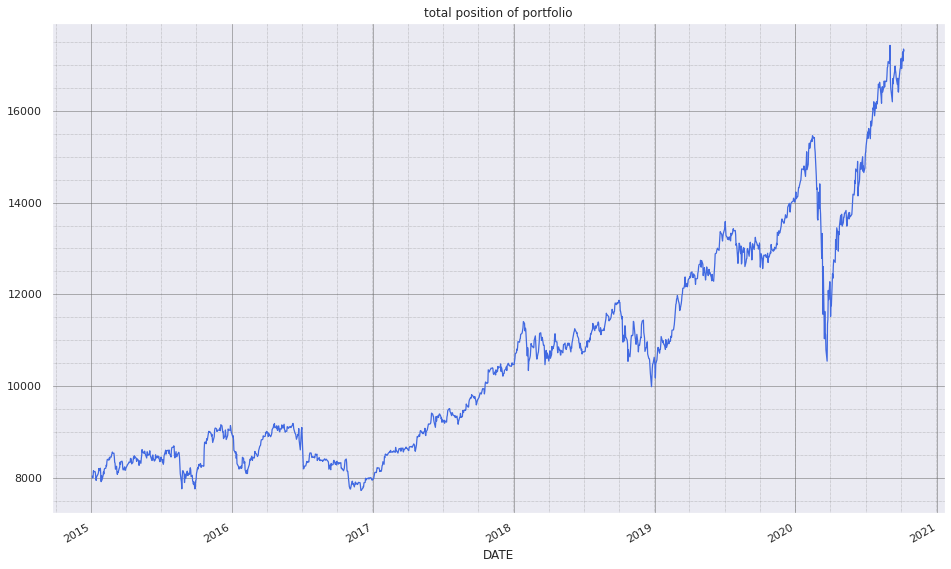

In [13]:
plt.figure()
plt.title("total position of portfolio")
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='dimgray')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')





pf_cum_ret['TOTAL_POS'].plot(color=['royalblue'], figsize=(16,10), linewidth=1.25);


MSFT         1285.462251
DHR          3136.904523
ATR           280.446148
HXGBY        1043.528016
NVS           405.295842
NVZMY        1021.203359
MCD           862.661826
TOTAL_POS    8035.501965
Name: 2015-01-05 00:00:00, dtype: float64


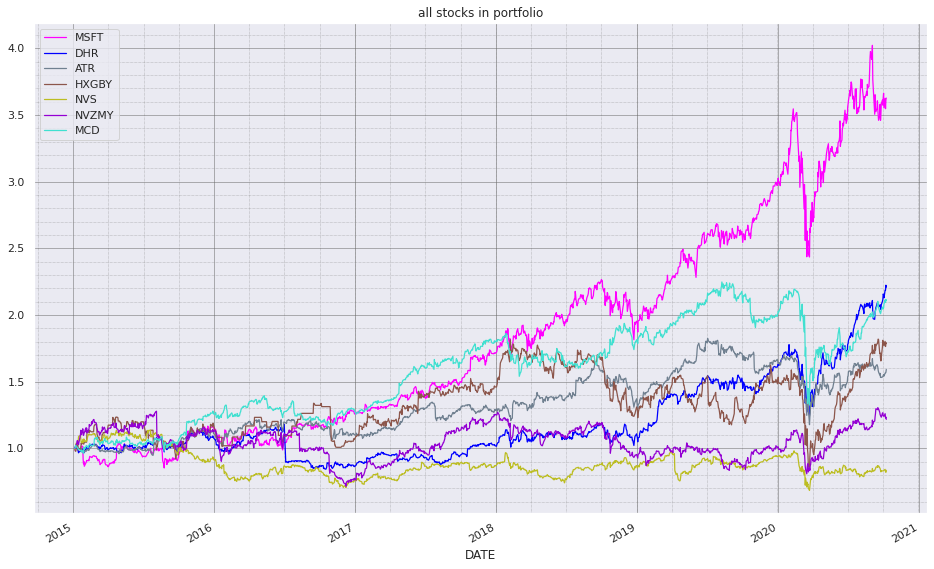

In [14]:
pf_cum_ret.head()
color_list = [color_dict.get(x, _) for x in pf_cum_ret.columns]
print(pf_cum_ret.iloc[0])
#pf_cum_ret.fillna(method='ffill', inplace=True)
_pf_cum_ret  = pf_cum_ret / pf_cum_ret.iloc[0]

_pf_cum_ret[symbol_list].plot(color=color_list,figsize=(16,10), linewidth=1.25);


plt.title('all stocks in portfolio')
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='dimgray')
# Customize the minor grid
plt.grid( which='minor', linestyle=':', linewidth='0.5', color='gray')





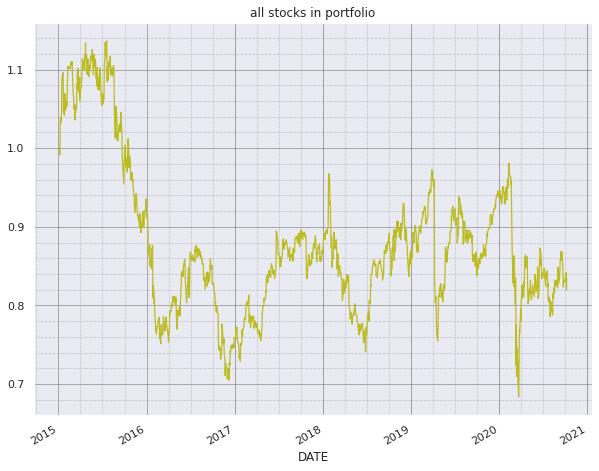

In [15]:
plt.close('all')

color_list_nvs = [color_dict.get('NVS', _)]
plt.title('all stocks in portfolio')
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='dimgray')
# Customize the minor grid
plt.grid( which='minor', linestyle=':', linewidth='0.5', color='gray')
_pf_cum_ret['NVS'].plot(color=color_list_nvs,figsize=(10,8), linewidth=1.25);

# Sharpe Ratio

In [16]:
pf_cum_ret['DAILY_RETURN']= pf_cum_ret['TOTAL_POS'].pct_change(1)

print('\nvolatility daily:\t',pf_cum_ret['DAILY_RETURN'].std())
print('return daily: \t\t', pf_cum_ret['DAILY_RETURN'].mean())

actual_annual_volatility = pf_cum_ret['DAILY_RETURN'].std() * 252 **0.5
actual_annual_return = pf_cum_ret['DAILY_RETURN'].mean() * 252

print('\n\nvolatility annually:\t',actual_annual_volatility )
print('return annually:\t', actual_annual_return )
      
cum_return = 100 * ( ( pf_cum_ret['TOTAL_POS'][-1] - pf_cum_ret['TOTAL_POS'][0] ) / pf_cum_ret['TOTAL_POS'][0] )
print('\naccumulated return: \t',cum_return)


#calculate sharpe ratio daily assume risk-free rate to be zero
actual_sharp_ratio = pf_cum_ret['DAILY_RETURN'].mean() / pf_cum_ret['DAILY_RETURN'].std()

# annualize Sharpe Ratio 
# annual sharpe ratio (asr) should be above 1 


print('\nannual sharp ratio should be above 1')
actual_sharp_ratio_annual = (252**0.5)*actual_sharp_ratio

print('\nsharp_ratio:\t\t', actual_sharp_ratio)

print('annual_sharp_ratio:\t',actual_sharp_ratio_annual)

              




volatility daily:	 0.01198572567374953
return daily: 		 0.0006014050223954102


volatility annually:	 0.19026749649230004
return annually:	 0.15155406564364338

accumulated return: 	 115.36149322884694

annual sharp ratio should be above 1

sharp_ratio:		 0.05017677183389689
annual_sharp_ratio:	 0.7965315591871291


In [17]:
#correction of  calculating annual return and annual volatility
# use log returns 
# use 252 days!
log_ret= np.log(pf/pf.shift(1))

pf_cum_ret['DAILY_RETURN']= np.log(pf_cum_ret['TOTAL_POS']/pf_cum_ret['TOTAL_POS'].shift(1))

print('\nvolatility daily:\t',pf_cum_ret['DAILY_RETURN'].std())
print('return daily: \t\t', pf_cum_ret['DAILY_RETURN'].mean())

actual_annual_volatility = pf_cum_ret['DAILY_RETURN'].std() * 252 **0.5
actual_annual_return = pf_cum_ret['DAILY_RETURN'].mean() * 252

print('\n\nvolatility annually:\t',actual_annual_volatility )
print('return annually:\t', actual_annual_return )
      
cum_return = 100 * ( ( pf_cum_ret['TOTAL_POS'][-1] - pf_cum_ret['TOTAL_POS'][0] ) / pf_cum_ret['TOTAL_POS'][0] )
print('\naccumulated return: \t',cum_return)


#calculate sharpe ratio daily assume risk-free rate to be zero
actual_sharp_ratio = pf_cum_ret['DAILY_RETURN'].mean() / pf_cum_ret['DAILY_RETURN'].std()

# annualize Sharpe Ratio 
# annual sharpe ratio (asr) should be above 1 


print('\nannual sharp ratio should be above 1')
actual_sharp_ratio_annual = (252**0.5)*actual_sharp_ratio

print('\nsharp_ratio:\t\t', actual_sharp_ratio)

print('annual_sharp_ratio:\t',actual_sharp_ratio_annual)



volatility daily:	 0.012085171509048798
return daily: 		 0.000528702821560902


volatility annually:	 0.19184615018703777
return annually:	 0.1332331110333473

accumulated return: 	 115.36149322884694

annual sharp ratio should be above 1

sharp_ratio:		 0.04374806109826697
annual_sharp_ratio:	 0.6944789400436419


,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD,TOTAL_POS,DAILY_RETURN
DATE,,,,,,,,,
2015-01-05,1285.462251,3136.904523,280.446148,1043.528016,405.295842,1021.203359,862.661826,8035.501965,NaN
2015-01-06,1266.594024,3115.393389,277.434559,1039.423672,401.861857,1032.057372,864.250436,7997.015309,-0.004801
2015-01-07,1282.585193,3134.186404,279.036104,1020.477563,403.611558,1017.532676,879.179654,8016.609151,0.002447
2015-01-08,1319.772105,3182.233500,286.869061,1020.477563,417.401273,1044.754288,882.446769,8153.954559,0.016987
2015-01-09,1308.632371,3160.726829,284.078399,1044.092973,421.108817,1040.231535,871.625993,8130.496918,-0.002881
...,...,...,...,...,...,...,...,...,...
2020-10-02,4568.252812,6678.030536,432.264812,1846.458729,338.379927,1265.908409,1795.165793,16924.461017,-0.013025
2020-10-05,4660.153932,6859.387758,438.727994,1880.299450,341.267310,1286.121746,1822.369432,17288.327622,0.021272
2020-10-06,4560.071351,6855.931277,438.766293,1840.200434,334.157317,1254.056391,1806.338177,17089.521240,-0.011566


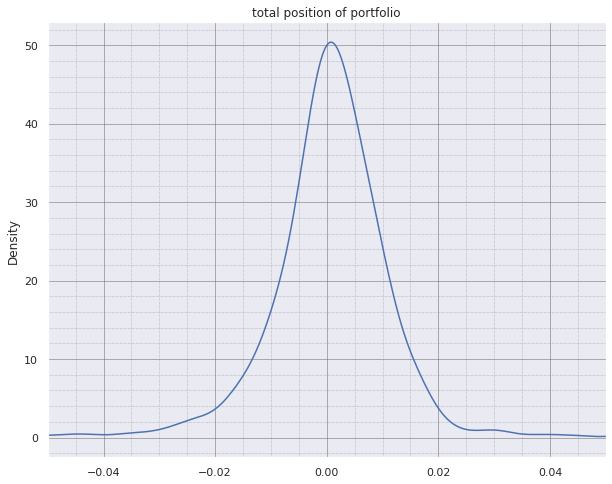

In [18]:
plt.close('all')
plt.figure()
plt.title("total position of portfolio")
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='dimgray')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

pf_cum_ret['DAILY_RETURN'].plot(kind='kde', figsize=(10,8), xlim=[-.05,.05]);
pf_cum_ret


# portfolio optimization
# - monte carlo
# - mathematical optimization by minimizing the negative sharpe ratio

In [19]:
pf


,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
DATE,,,,,,,
2015-01-02,46.760,85.72,66.65,31.060,92.25,41.840,93.26
2015-01-05,46.325,84.87,64.60,30.570,92.45,40.710,92.23
2015-01-06,45.650,84.29,63.91,30.450,91.67,41.145,92.40
2015-01-07,46.230,84.80,64.28,29.900,92.07,40.570,94.01
2015-01-08,47.590,86.11,66.11,29.900,95.27,41.670,94.36
...,...,...,...,...,...,...,...
2020-10-02,206.190,212.50,112.85,75.150,87.52,62.750,222.67
2020-10-05,210.380,218.35,114.55,76.540,88.27,63.760,226.07
2020-10-06,205.910,218.24,114.56,74.925,86.45,62.190,224.09


In [20]:
# annual mean of returns as %
type(pf.pct_change(1).mean()*252)
(pf.pct_change(1).mean()*252).sort_values(ascending=False)


MSFT     0.300254
HXGBY    0.210948
DHR      0.191058
MCD      0.179208
ATR      0.118774
NVZMY    0.104417
NVS      0.012447
dtype: float64

In [21]:
# we use log returns for algorithms especially for normalizations
log_ret= np.log(pf/pf.shift(1))

log_ret.head()

log_ret.fillna(value=0.0,inplace=True)
log_ret.to_csv('../data/log_ret2.csv')

In [22]:
(log_ret.mean()*252).sort_values(ascending=False)

MSFT     0.260990
DHR      0.164028
HXGBY    0.154860
MCD      0.153361
ATR      0.096882
NVZMY    0.067227
NVS     -0.009089
dtype: float64

In [23]:
# annual variance
print((log_ret.var()*252).sort_values(ascending=False))

# annual standard deviation
print((log_ret.std()*252**0.5).sort_values(ascending=False))

HXGBY    0.112466
MSFT     0.077884
NVZMY    0.074760
DHR      0.054448
MCD      0.051363
ATR      0.043606
NVS      0.043285
dtype: float64
HXGBY    0.335360
MSFT     0.279077
NVZMY    0.273423
DHR      0.233341
MCD      0.226634
ATR      0.208820
NVS      0.208051
dtype: float64


In [24]:
log_ret.corr() 

,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
MSFT,1.000000,0.553668,0.480430,0.416348,0.492192,0.289080,0.514752
DHR,0.553668,1.000000,0.459710,0.332277,0.482921,0.237738,0.456432
ATR,0.480430,0.459710,1.000000,0.354402,0.409884,0.263924,0.460613
HXGBY,0.416348,0.332277,0.354402,1.000000,0.328560,0.258943,0.351123
NVS,0.492192,0.482921,0.409884,0.328560,1.000000,0.318927,0.402406
NVZMY,0.289080,0.237738,0.263924,0.258943,0.318927,1.000000,0.182235
MCD,0.514752,0.456432,0.460613,0.351123,0.402406,0.182235,1.000000


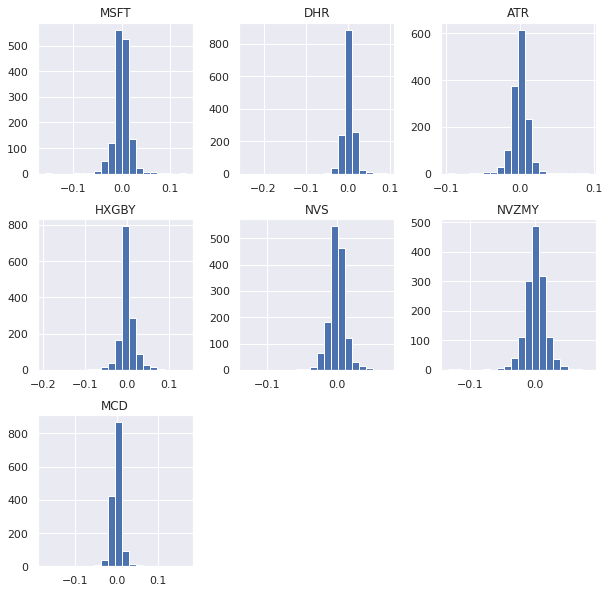

In [25]:
log_ret.hist(bins=20, figsize=(10,10));

#type(hist)



In [26]:
np.random.seed(101)
# to keep getting the same random weights

print(pf.columns)
num_weights = len(log_ret.columns)
weights = np.array(np.random.random(num_weights))
pprint.pprint(weights)
print('sum:',np.sum(weights))
# but they do not add up to 1

print('\n rebalance: \n')
weights=weights/np.sum(weights)
print(weights)
np.sum(weights)

Index(['MSFT', 'DHR', 'ATR', 'HXGBY', 'NVS', 'NVZMY', 'MCD'], dtype='object')
array([0.51639863, 0.57066759, 0.02847423, 0.17152166, 0.68527698,
       0.83389686, 0.30696622])
sum: 3.1132021612794123

 rebalance: 

[0.16587379 0.18330566 0.00914628 0.05509493 0.22011965 0.26785824
 0.09860144]


1.0000000000000002

In [27]:
#
print('expected portfolio return')
some_exp_ret = np.sum((log_ret.mean() * weights) * 252)
print((log_ret.mean() * weights) * 252)
some_exp_ret
print(some_exp_ret)
print('\n expected volatility')
#denominator of sharp-ratio

some_exp_vol = np.sqrt(np.dot((weights.T),np.dot(log_ret.cov()*252, weights)))
print(some_exp_vol)

some_sr = some_exp_ret / some_exp_vol
print('\n sharpe ratio: ')
print(some_sr)

expected portfolio return
MSFT     0.043291
DHR      0.030067
ATR      0.000886
HXGBY    0.008532
NVS     -0.002001
NVZMY    0.018007
MCD      0.015122
dtype: float64
0.11390491444219943

 expected volatility
0.17478582979695215

 sharpe ratio: 
0.6516827741386256



## determine number of iterations in monte carlo

In [28]:
import numpy as np

np.random.seed(101)

num_pf = 10000

num_weights = len(log_ret.columns)
all_weights = np.zeros((num_pf, num_weights))
ret_arr = np.zeros(num_pf)
vol_arr = np.zeros(num_pf)
sharpe_arr = np.zeros(num_pf)

for ind in range(num_pf):
    _weights = np.array(np.random.random(num_weights))
    _weights = _weights / np.sum(_weights)
    all_weights[ind,:] = _weights
    # expected return
    ret_arr[ind] = np.sum((log_ret.mean() * _weights) * 252)
    #expected volatility
    vol_arr[ind] = np.sqrt(np.dot((_weights.T),np.dot(log_ret.cov()*252, _weights)))
    #sharpe ratio
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
    
print('done')

done


In [29]:
print(sharpe_arr.max())
mc_sharp_ratio_annual = sharpe_arr.max()
sharpe_arr


0.9520022255720519


array([0.65168277, 0.85373505, 0.76245447, ..., 0.73484088, 0.73924672,
       0.72053476])

In [30]:
sharp_argmax = sharpe_arr.argmax()
sharp_argmax

2752

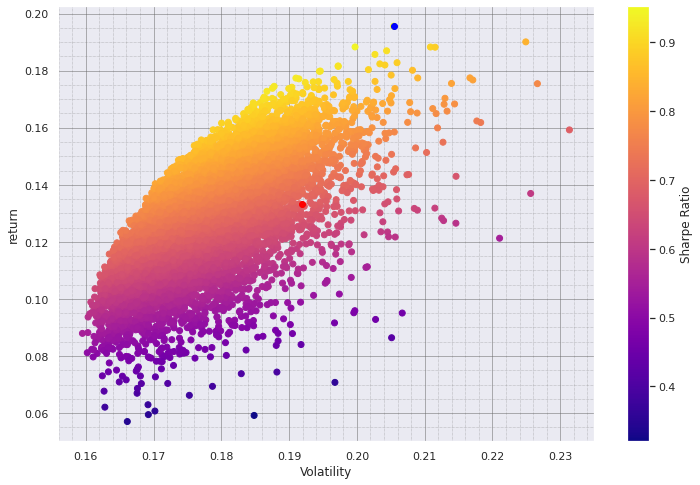

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr, c= sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('return')



# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='dimgray')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')


max_sr_ret = ret_arr[sharp_argmax]
max_sr_vol = vol_arr[sharp_argmax]
plt.scatter(max_sr_vol, max_sr_ret,  c='blue')
plt.scatter(actual_annual_volatility, actual_annual_return,  c='red')

In [32]:
log_ret.head()

,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
DATE,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.009346,-0.009965,-0.031241,-0.015902,0.002166,-0.027379,-0.011106
2015-01-06,-0.014678,-0.006857,-0.010739,-0.003933,-0.008473,0.010629,0.001842
2015-01-07,0.012625,0.006032,0.005773,-0.018228,0.004354,-0.014074,0.017274
2015-01-08,0.028994,0.015330,0.028071,0.000000,0.034166,0.026753,0.003716


# Machine Learning Approach 

In [33]:
from scipy.optimize import minimize 
import numpy as np


In [34]:
#helper functions

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights)  * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    sr = ret / vol
    return np.array([ret,vol,sr])

#minimize negative sharpe ratio which is the same as maximize sr
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [35]:
"""
#constraint in form of dictionary
cons = ({'type': 'eq', 'fun':check_sum})
#defines a constraint for minimize function - it says
#{Constraint, dict} or List of {Constraint, dict}
# type will be equations and a function

bounds = ((0,1),(0,1), (0,1),(0,1),(0,1),(0,1), (0,1))
#bounds : sequence or `Bounds`, optional
#        Bounds on variables for L-BFGS-B, TNC, SLSQP and
#        trust-constr methods. There are two ways to specify the bounds:
#    
#           1. Instance of `Bounds` class.
#           2. Sequence of ``(min, max)`` pairs for each element in `x`. None
#               is used to specify no bound.



#sum of weights is 1 
init_guess = [0.25,0.25,0.25,0.25, 0.25,0.25,0.25]
"""

"\n#constraint in form of dictionary\ncons = ({'type': 'eq', 'fun':check_sum})\n#defines a constraint for minimize function - it says\n#{Constraint, dict} or List of {Constraint, dict}\n# type will be equations and a function\n\nbounds = ((0,1),(0,1), (0,1),(0,1),(0,1),(0,1), (0,1))\n#bounds : sequence or `Bounds`, optional\n#        Bounds on variables for L-BFGS-B, TNC, SLSQP and\n#        trust-constr methods. There are two ways to specify the bounds:\n#    \n#           1. Instance of `Bounds` class.\n#           2. Sequence of ``(min, max)`` pairs for each element in `x`. None\n#               is used to specify no bound.\n\n\n\n#sum of weights is 1 \ninit_guess = [0.25,0.25,0.25,0.25, 0.25,0.25,0.25]\n"

In [36]:
cons = ({'type': 'eq', 'fun':check_sum})
_num_symbols = len(pf.columns)
bounds = [(0,1) for x in pf.columns] 
init_guess = [0.25 for x in pf.columns]
print(bounds)
print(init_guess)

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


In [37]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds,constraints=cons )
opt_results

     fun: -0.9781947941148045
     jac: array([-4.17828560e-05,  2.25678086e-05,  7.11753592e-02,  3.12775373e-05,
        5.48170179e-01,  6.37584701e-02,  8.74176621e-05])
 message: 'Optimization terminated successfully.'
    nfev: 54
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([5.66212823e-01, 2.04443687e-01, 8.99887803e-18, 1.79767180e-02,
       9.16150836e-17, 0.00000000e+00, 2.11366773e-01])

In [38]:
if (np.sum(opt_results.x)) == 1:
    print("ok")

get_ret_vol_sr(opt_results.x)

ok


array([0.21650979, 0.22133607, 0.97819479])

In [39]:
# create an array of possible returns  y-values
frontier_y = np.linspace(0,0.25,100)
frontier_y

array([0.        , 0.00252525, 0.00505051, 0.00757576, 0.01010101,
       0.01262626, 0.01515152, 0.01767677, 0.02020202, 0.02272727,
       0.02525253, 0.02777778, 0.03030303, 0.03282828, 0.03535354,
       0.03787879, 0.04040404, 0.04292929, 0.04545455, 0.0479798 ,
       0.05050505, 0.0530303 , 0.05555556, 0.05808081, 0.06060606,
       0.06313131, 0.06565657, 0.06818182, 0.07070707, 0.07323232,
       0.07575758, 0.07828283, 0.08080808, 0.08333333, 0.08585859,
       0.08838384, 0.09090909, 0.09343434, 0.0959596 , 0.09848485,
       0.1010101 , 0.10353535, 0.10606061, 0.10858586, 0.11111111,
       0.11363636, 0.11616162, 0.11868687, 0.12121212, 0.12373737,
       0.12626263, 0.12878788, 0.13131313, 0.13383838, 0.13636364,
       0.13888889, 0.14141414, 0.14393939, 0.14646465, 0.1489899 ,
       0.15151515, 0.1540404 , 0.15656566, 0.15909091, 0.16161616,
       0.16414141, 0.16666667, 0.16919192, 0.17171717, 0.17424242,
       0.17676768, 0.17929293, 0.18181818, 0.18434343, 0.18686

In [40]:
frontier_volatility = []
#for a possible return what is the risk
#in order to get the return/volatility combinations on the efficient frontier 
#we add the second constraint
for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},{'type':'eq', 'fun':lambda w: (get_ret_vol_sr(w)[0]-possible_return)})
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(result['fun'])
#   print(result['fun'])
    
print('done - frontier volatility calculated')    
#frontier_volatility
    

done - frontier volatility calculated


In [41]:
frontier_sr = frontier_y / frontier_volatility
print('\nmax sharp ratio calculated:\t\t',frontier_sr.max())

print('number of argument in array frontier_sr:\t',frontier_sr.argmax())

max_sr_ret_calc = frontier_y[frontier_sr.argmax()]
max_sr_vol_calc = frontier_volatility[frontier_sr.argmax()]
ml_sharp_ratio_annual = max_sr_ret_calc / max_sr_vol_calc

print('\n\nmax return calculated:\t\t',frontier_volatility[frontier_sr.argmax()])
print('max volatility calculated:\t',frontier_y[frontier_sr.argmax()])


max sharp ratio calculated:		 0.9781815705821602
number of argument in array frontier_sr:	 86


max return calculated:		 0.222015752190535
max volatility calculated:	 0.21717171717171718




actual x-value of Pf:		 0.19184615018703777
actual  y-value of Pf:		 0.1332331110333473

monte_carlo x-value-max:	 0.20543300349940177
monte_carlo y-value-max:	 0.1955726765373816

Machine_L x-value-max:		 0.222015752190535
Machine_L y-value-max:		 0.21717171717171718


actual sharp-ratio-annual:	 0.6944789400436419
monte_carlo sharp_ratio-annual:	 0.9520022255720519
Machine_L sharp_ratio-annual:	 0.9781815705821602

overall return improvement:	 0.08393860613836987
return improvement to actual:	 0.630013106256752


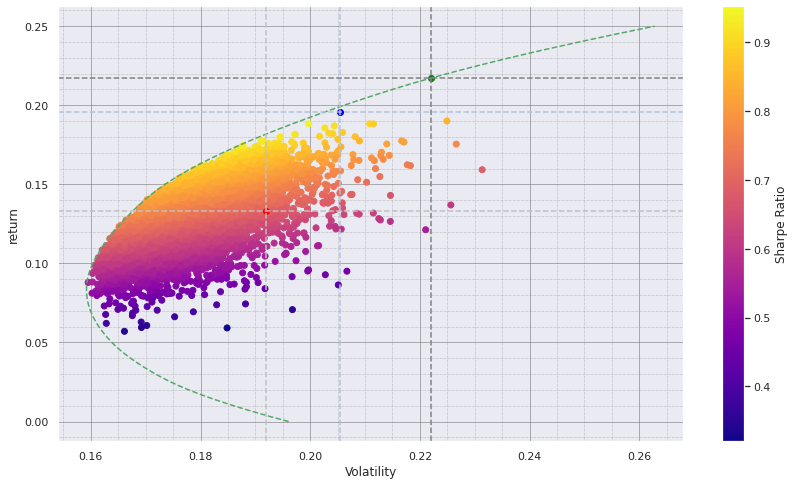

In [42]:
plt.close('all')
# calculated efficient frontier
plt.figure(figsize=(14,8))
plt.plot(frontier_volatility,frontier_y, 'g--');

# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='dimgray')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')


#scatter-plot from monte carlo simulation
plt.scatter(vol_arr,ret_arr, c= sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('return')

# actual portfolio Volatility/Return - red
print('\n\nactual x-value of Pf:\t\t', actual_annual_volatility)
print('actual  y-value of Pf:\t\t', actual_annual_return)
plt.scatter(actual_annual_volatility, actual_annual_return,  c='red')
plt.axhline(actual_annual_return, color='silver',linestyle='--')
plt.axvline(actual_annual_volatility, color='silver', linestyle='--');

# Monte-Carlo Volatility/Return  - blue
print('\nmonte_carlo x-value-max:\t', max_sr_vol)
print('monte_carlo y-value-max:\t', max_sr_ret)
plt.scatter(max_sr_vol, max_sr_ret,  c='blue');
plt.axhline(max_sr_ret, color='lightsteelblue',linestyle='--')
plt.axvline(max_sr_vol, color='lightsteelblue', linestyle='--');



# Machine_Learning calculated Volatility/Return - green
print('\nMachine_L x-value-max:\t\t', max_sr_vol_calc)
print('Machine_L y-value-max:\t\t', max_sr_ret_calc)
plt.scatter(max_sr_vol_calc, max_sr_ret_calc,  c='green');
plt.axhline(max_sr_ret_calc, color='gray',linestyle='--')
plt.axvline(max_sr_vol_calc, color='gray', linestyle='--');

# sharpe-Ratios
print('\n\nactual sharp-ratio-annual:\t',actual_sharp_ratio_annual)
print('monte_carlo sharp_ratio-annual:\t',mc_sharp_ratio_annual)
print('Machine_L sharp_ratio-annual:\t',ml_sharp_ratio_annual)

print('\noverall return improvement:\t',max_sr_ret_calc - actual_annual_return )
print('return improvement to actual:\t',(max_sr_ret_calc - actual_annual_return)/actual_annual_return )

In [43]:
import pandas as pd

actual_weights
mc_weights = all_weights[sharp_argmax,:]
ml_weights = np.round((opt_results.x),decimals=6)

#ml_weights = opt_results.x

print(ml_weights)


w_data = {'symbol': symbol_list,
          'actual_weights': actual_weights,
          'mc_weights': mc_weights,
          'ml_weights': ml_weights,
        }
w_data

df_weights_compare = pd.DataFrame(w_data, columns = ['symbol','actual_weights','mc_weights','ml_weights'])
df_weights_compare['diff_%'] = (ml_weights - actual_weights) / actual_weights * 100

print('\n',df_weights_compare)



[0.566213 0.204444 0.       0.017977 0.       0.       0.211367]

   symbol  actual_weights  mc_weights  ml_weights      diff_%
0   MSFT        0.159357    0.397960    0.566213  255.311432
1    DHR        0.389121    0.245540    0.204444  -47.459980
2    ATR        0.035552    0.010421    0.000000 -100.000000
3  HXGBY        0.130226    0.135579    0.017977  -86.195572
4    NVS        0.049667    0.005513    0.000000 -100.000000
5  NVZMY        0.128944    0.022739    0.000000 -100.000000
6    MCD        0.107133    0.182248    0.211367   97.293716


In [44]:
print('\nact. sharp-ratio-annual:\t',actual_sharp_ratio_annual)
print('mc sharp-ratio-annual:\t\t',mc_sharp_ratio_annual)
print('ml sharp-ratio-annual:\t\t',ml_sharp_ratio_annual)
print('difference: \t\t\t',(ml_sharp_ratio_annual-actual_sharp_ratio_annual))


act. sharp-ratio-annual:	 0.6944789400436419
mc sharp-ratio-annual:		 0.9520022255720519
ml sharp-ratio-annual:		 0.9781815705821602
difference: 			 0.2837026305385183


# ######
# CAPM
*return of stock i at time t = beta of stock i * return of market at time t + alpha of stock i at time t
## Y = m*x+b*
## return of i = beta * x + alpha*
## if beta is 1 it moves exactly as quickly as the market
## predict alpha more than 50% of the time an you can make profit#
## return of portfolio = beta of portfolio * market return + sum of (alphas of stocks *weight of i)
## beta says that there is a relation between our portfolio and the market return
## capm says alpha cannot be predicted but we will disagree with that notion

In [45]:
from scipy import stats
import pandas as pd
import numpy as np


In [46]:
# help(stats.linregress)


In [48]:
print('root_path:',root_path)
### create dataframe with portfolio adjusted close
usecols = ["timestamp", "close"]
path_list = create_path_list(symbol_list, root_path)
pprint.pprint(path_list)
print(startd)
print(endd)

pf = retrievePF(symbol_list, path_list, startd, endd, usecols, rename_column)
print(pf.index.name)
pf.index.rename('DATE', inplace=True)
print(pf.index.name)
pf.fillna(method='ffill', inplace=True)
pf



root_path: /home/pi/Documents/Python
{'ATR': '/home/pi/Documents/Python/data/ATR/daily_ATR.csv',
 'DHR': '/home/pi/Documents/Python/data/DHR/daily_DHR.csv',
 'HXGBY': '/home/pi/Documents/Python/data/HXGBY/daily_HXGBY.csv',
 'MCD': '/home/pi/Documents/Python/data/MCD/daily_MCD.csv',
 'MSFT': '/home/pi/Documents/Python/data/MSFT/daily_MSFT.csv',
 'NVS': '/home/pi/Documents/Python/data/NVS/daily_NVS.csv',
 'NVZMY': '/home/pi/Documents/Python/data/NVZMY/daily_NVZMY.csv'}
2015-01-01
2020-10-09
None
DATE


,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
DATE,,,,,,,
2015-01-02,46.760,85.72,66.65,31.060,92.25,41.840,93.26
2015-01-05,46.325,84.87,64.60,30.570,92.45,40.710,92.23
2015-01-06,45.650,84.29,63.91,30.450,91.67,41.145,92.40
2015-01-07,46.230,84.80,64.28,29.900,92.07,40.570,94.01
2015-01-08,47.590,86.11,66.11,29.900,95.27,41.670,94.36
...,...,...,...,...,...,...,...
2020-10-02,206.190,212.50,112.85,75.150,87.52,62.750,222.67
2020-10-05,210.380,218.35,114.55,76.540,88.27,63.760,226.07
2020-10-06,205.910,218.24,114.56,74.925,86.45,62.190,224.09


In [49]:
#from datetime import datetime, timedelta

#from myauz.myalpha_funcs import string2date, date2string

#endd = '2020-10-03'
#endd_date_object = string2date(endd)
#endd_date_object = endd_date_object + timedelta(days=1)
#endd = date2string(endd_date_object)
#pf[startd:endd]

In [50]:
invested_dict = {
    "MSFT": float(1297.59),
#   "GOOG": float(2111),
    "DHR": float(3168.48),
#   "EMR": float(418.10),
    "ATR": float(289.49),
    "HXGBY": float(1060.39),
    "NVS": float(404.42),
    "NVZMY": float(1049.95),
#   "CL": float(390.03),
    "MCD": float(872.35),  
#   "HEINY": float(575.60),     
#   "LDSVF": float(6942.25),   
}

In [51]:
total_investment, weights_dict = calc_weights(invested_dict)

print("total investment:",total_investment)

weight_sum = 0
for symbol, weight in weights_dict.items():
    pprint.pprint((symbol, weight))
    weight_sum += weight

print(weight_sum)

"""
weights = [
   .1,  #"MSFT",
   .1,  #"GOOG",    
   .1, #"DHR",
   .1,  #"EMR",
   .1,  #"ATR",
   .1,  #"HXGBY",
   .1,  #"NVS",
   .1,  #"NVZMY",    
   .1,  #"CL",
   .05,  #"MCD",    
   .03,  #"HEINY",
   .02,  #"LDSVF",  
]
"""

total investment: 8142.67
('MSFT', 0.15935682030587017)
('DHR', 0.38912052189269614)
('ATR', 0.03555222058612224)
('HXGBY', 0.1302263262541648)
('NVS', 0.049666755499117615)
('NVZMY', 0.1289441915244017)
('MCD', 0.10713316393762734)
1.0


'\nweights = [\n   .1,  #"MSFT",\n   .1,  #"GOOG",    \n   .1, #"DHR",\n   .1,  #"EMR",\n   .1,  #"ATR",\n   .1,  #"HXGBY",\n   .1,  #"NVS",\n   .1,  #"NVZMY",    \n   .1,  #"CL",\n   .05,  #"MCD",    \n   .03,  #"HEINY",\n   .02,  #"LDSVF",  \n]\n'

In [52]:
# we use log returns for algorithms especially for normalizations
#log_ret= np.log(pf/pf.shift(1))

#df_returns = (pf/pf.shift(1))-1
df_returns = np.log(pf/(pf.shift(1)))
df_cum_returns = initialize_df(symbol_list, startd, endd)
#print(df_cum_returns.head())
#print(df_returns)

df_cum_returns = (1+df_returns).cumprod()
###############achtung dataframe wird auf naechtes datum ohne NaN gesetzt
#df_cum_returns.dropna(inplace=True)
#################
df_cum_returns
#df_cum_returns.head()



,MSFT,DHR,ATR,HXGBY,NVS,NVZMY,MCD
DATE,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.990654,0.990035,0.968759,0.984098,1.002166,0.972621,0.988894
2015-01-06,0.976113,0.983245,0.958356,0.980228,0.993675,0.982959,0.990715
2015-01-07,0.988436,0.989177,0.963889,0.962361,0.998001,0.969125,1.007829
2015-01-08,1.017095,1.004341,0.990946,0.962361,1.032098,0.995051,1.011574
...,...,...,...,...,...,...,...
2020-10-02,3.520567,2.107645,1.493194,1.741302,0.836704,1.205684,2.057850
2020-10-05,3.591392,2.164883,1.515520,1.773215,0.843844,1.224936,2.089035
2020-10-06,3.514262,2.163792,1.515653,1.735400,0.826263,1.194396,2.070658


In [53]:
#ensure that weights vector is in correct order as symbol_list
wlist = []
for symbol in symbol_list:
    print(symbol)
    wlist.append(weights_dict[symbol])

print('wlist',wlist)
#weights = np.array(list(weights_dict.values()))
actual_weights=np.array(wlist)

print('\n',actual_weights.sum())




# pf_cum_ret = df_cum_returns * actual_weights * total_investment


pf_cum_ret = df_cum_returns * actual_weights 

pf_cum_ret.fillna(method='ffill', inplace=True, axis=1)
pf_cum_ret['TOTAL_POS'] = pf_cum_ret.sum(axis=1)
pf_cum_ret

print('\n _________________________________________________________________________________')

#pf_cum_ret = pf_cum_ret[1:]

print(pf_cum_ret['TOTAL_POS'])
pf_cum_ret.to_csv('../data/pf_cum_ret.csv')

new_endd = myauz.myalpha_funcs.date2string(pf_cum_ret.index[-1])

MSFT
DHR
ATR
HXGBY
NVS
NVZMY
MCD
wlist [0.15935682030587017, 0.38912052189269614, 0.03555222058612224, 0.1302263262541648, 0.049666755499117615, 0.1289441915244017, 0.10713316393762734]

 1.0

 _________________________________________________________________________________
DATE
2015-01-02    0.000000
2015-01-05    0.986839
2015-01-06    0.982112
2015-01-07    0.984518
2015-01-08    1.001386
                ...   
2020-10-02    2.078490
2020-10-05    2.123177
2020-10-06    2.098761
2020-10-07    2.130701
2020-10-08    2.125271
Name: TOTAL_POS, Length: 1453, dtype: float64


In [54]:

df_returns_weighted = df_returns * actual_weights
df_returns_weighted['DAILY_RETURN'] = df_returns_weighted.sum(axis=1)
df_returns_weighted = df_returns_weighted[1:]
print(df_returns_weighted.head())

return_annual_mean = df_returns_weighted['DAILY_RETURN'].mean()*252
print('\n\nAnnual Return of Portfolio:\t',return_annual_mean)

                MSFT       DHR       ATR     HXGBY       NVS     NVZMY  \
DATE                                                                     
2015-01-05 -0.001489 -0.003878 -0.001111 -0.002071  0.000108 -0.003530   
2015-01-06 -0.002339 -0.002668 -0.000382 -0.000512 -0.000421  0.001371   
2015-01-07  0.002012  0.002347  0.000205 -0.002374  0.000216 -0.001815   
2015-01-08  0.004620  0.005965  0.000998  0.000000  0.001697  0.003450   
2015-01-09 -0.001345 -0.002630 -0.000346  0.003014  0.000441 -0.000558   

                 MCD  DAILY_RETURN  
DATE                                
2015-01-05 -0.001190     -0.013161  
2015-01-06  0.000197     -0.004754  
2015-01-07  0.001851      0.002443  
2015-01-08  0.000398      0.017128  
2015-01-09 -0.001314     -0.002738  


Annual Return of Portfolio:	 0.15378130376974894


In [57]:
usecols = ["timestamp", "close"]
spy_etf = get_daily_symbol("SPY", root_path, startd = startd, endd=endd, wd = None, usecols = usecols)
spy_etf=spy_etf[1:]
spy_etf=spy_etf.loc[startd:new_endd]
#spy_etf['DAILY_RETURN'] = spy_etf['adjusted_close'].pct_change(1)
spy_etf['DAILY_RETURN'] = np.log(spy_etf['close'] / spy_etf['close'].shift(1))

('Directory ', '/home/pi/Documents/Python/data/SPY', ' already exists')


In [58]:
#spy_etf = spy_etf[1:]
spy_etf

,open,high,low,close,volume,DAILY_RETURN
timestamp,,,,,,
2015-01-05,204.17,204.3700,201.35,201.72,169632646,NaN
2015-01-06,202.09,202.7200,198.86,199.82,209151408,-0.009464
2015-01-07,201.42,202.7200,200.88,202.31,125346709,0.012384
2015-01-08,204.01,206.1600,203.99,205.90,147217784,0.017589
2015-01-09,206.40,206.4200,203.51,204.25,158567288,-0.008046
...,...,...,...,...,...,...
2020-10-02,331.70,337.0126,331.19,333.84,89431112,-0.009540
2020-10-05,336.06,339.9600,336.01,339.76,45713108,0.017578
2020-10-06,339.91,342.1700,334.38,334.93,90128883,-0.014318


In [61]:
spy_etf['CUM'] = spy_etf['close'] / spy_etf['close'].iloc[0]
spy_etf.head()

,open,high,low,close,volume,DAILY_RETURN,CUM
timestamp,,,,,,,
2015-01-05,204.17,204.37,201.35,201.72,169632646,NaN,1.000000
2015-01-06,202.09,202.72,198.86,199.82,209151408,-0.009464,0.990581
2015-01-07,201.42,202.72,200.88,202.31,125346709,0.012384,1.002925
2015-01-08,204.01,206.16,203.99,205.90,147217784,0.017589,1.020722
2015-01-09,206.40,206.42,203.51,204.25,158567288,-0.008046,1.012542


In [62]:

spy_etf.info()
df_returns_weighted.info()
pf_cum_ret.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1452 entries, 2015-01-05 to 2020-10-08
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          1452 non-null   float64
 1   high          1452 non-null   float64
 2   low           1452 non-null   float64
 3   close         1452 non-null   float64
 4   volume        1452 non-null   int64  
 5   DAILY_RETURN  1451 non-null   float64
 6   CUM           1452 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 90.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1452 entries, 2015-01-05 to 2020-10-08
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSFT          1452 non-null   float64
 1   DHR           1452 non-null   float64
 2   ATR           1452 non-null   float64
 3   HXGBY         1452 non-null   float64
 4   NVS           1452 non-null   float64
 5   NVZMY   

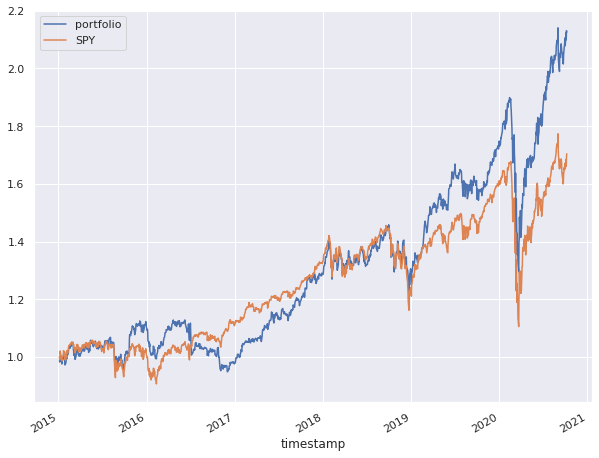

In [63]:
#plt.close('all')
pf_cum_ret['TOTAL_POS'].iloc[1:].plot(label='portfolio', figsize=(10,8))
spy_etf['CUM'].plot(label='SPY', figsize=(10,8))
plt.legend()

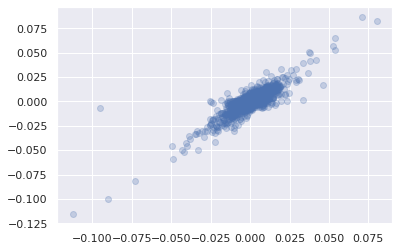

In [64]:
#plt.close('all')
plt.scatter(df_returns_weighted['DAILY_RETURN'], spy_etf['DAILY_RETURN'], alpha=0.25)

In [65]:
beta, alpha, r_value, p_value, std_err = stats.linregress(df_returns_weighted['DAILY_RETURN'].iloc[1:], spy_etf['DAILY_RETURN'].iloc[1:])

In [66]:
beta

0.8801874890227377

In [67]:
alpha

-0.00017806591988472952

In [68]:
r_value

0.8704283244539168

In [69]:
p_value

0.0

In [70]:
std_err

0.013077765819217118

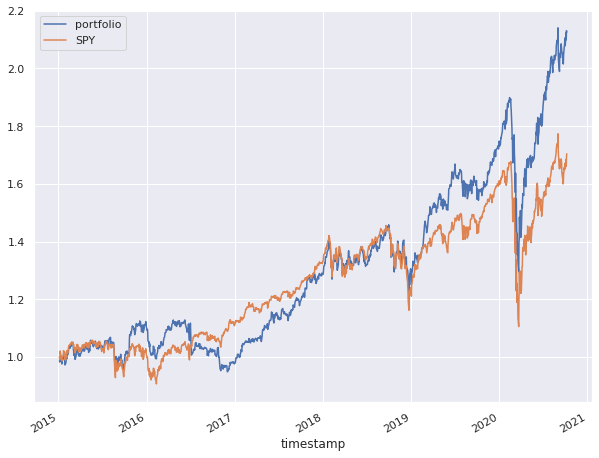

In [71]:
plt.close('all')
pf_cum_ret['TOTAL_POS'].iloc[1:].plot(label='portfolio', figsize=(10,8))
spy_etf['CUM'].plot(label='SPY', figsize=(10,8))
plt.legend()

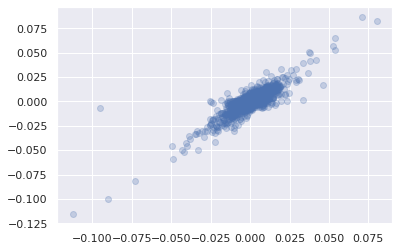

In [72]:
plt.close('all')
plt.scatter(df_returns_weighted['DAILY_RETURN'], spy_etf['DAILY_RETURN'], alpha=0.25)

In [73]:
# CAPM

In [74]:
#

sec_returns = initialize_df(['PORTFOLIO'], startd, endd)
sec_returns['PORTFOLIO'] = df_returns_weighted['DAILY_RETURN']
sec_returns['SPY'] = spy_etf['DAILY_RETURN']
sec_returns.dropna(axis=0,how='all',thresh=2,inplace=True)
sec_returns.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451 entries, 2015-01-06 to 2020-10-08
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PORTFOLIO  1451 non-null   float64
 1   SPY        1451 non-null   float64
dtypes: float64(2)
memory usage: 34.0 KB


In [75]:
cov = sec_returns.cov() *252
cov_pf_with_market = cov.iloc[0,1]
market_var = sec_returns['SPY'].var() *252
print(cov)
print('\n\n', cov_pf_with_market)
print('\n', market_var)

           PORTFOLIO       SPY
PORTFOLIO   0.033892  0.029831
SPY         0.029831  0.034656


 0.029830959246043197

 0.03465583603743083


In [76]:
pf_beta = cov_pf_with_market / market_var
pf_beta

0.8607773655733939

In [77]:
#expected return of the portfolio
# expected return = risk-free-return + beta(risk-premium)
# risk_premium = expected return of market-porfolio - risk-free-return

#choose risk_free_return of 5y treasury bonds or 10y Tbonds
#but also use then the market-portfolio starting 5 or 10y ago
#same think for your df_returns_weighted
risk_free_return = 0.009

#return_annual_mean = df_returns_weighted['DAILY_RETURN'].mean()*252
#calculate return_annual_mean of SPY market_portfolio!

print('\n\nAnnual Return of Portfolio:\t',return_annual_mean)
# inverstor's expected return
expected_return = risk_free_return + pf_beta*(return_annual_mean - risk_free_return)
expected_return



Annual Return of Portfolio:	 0.15378130376974894


0.13362446924320576